# Costa Rican Household Poverty Level Prediction

## Imports

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import sklearn
import random
from miceforest import ImputationKernel
import lightgbm as lgb

sns.set_theme(style="whitegrid")
sns.set_palette("crest")

In [30]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
test_ids = test["Id"]
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


## Preprocessing

### Dealing with mislabeled features

In [31]:
int_types = ["int16", "int32", "int64"]
float_types = ["float16", "float32", "float64"]
cat_types = ["object"]

int_cols = train.select_dtypes(include=int_types).columns
float_cols = train.select_dtypes(include=float_types).columns
cat_cols = train.select_dtypes(include=cat_types).columns

In [32]:
def num_values(train):
    return train.nunique()

def values_list(train):
    return list(train.value_counts().to_dict().keys())

tmp = train.select_dtypes(include=cat_types).drop(columns=["Id", "idhogar"]).agg([values_list, num_values])
print(f"dependency values: \n\t{tmp["dependency"]["num_values"]} - {tmp["dependency"]["values_list"]}")
print(f"edjefe values: \n\t{tmp["edjefe"]["num_values"]} - {tmp["edjefe"]["values_list"]}")
print(f"edjefa values: \n\t{tmp["edjefa"]["num_values"]} - {tmp["edjefa"]["values_list"]}")

dependency values: 
	31 - ['yes', 'no', '.5', '2', '1.5', '.33333334', '.66666669', '8', '.25', '3', '4', '.75', '.2', '.40000001', '1.3333334', '2.5', '5', '1.25', '3.5', '.80000001', '2.25', '.71428573', '1.75', '1.2', '.83333331', '.22222222', '.2857143', '1.6666666', '.60000002', '6', '.16666667']
edjefe values: 
	22 - ['no', '6', '11', '9', '3', '15', '8', '7', '5', '14', '17', '2', '4', '16', 'yes', '12', '10', '13', '21', '18', '19', '20']
edjefa values: 
	22 - ['no', '6', '11', '9', '8', '15', '7', '5', '3', '4', '14', '16', '10', '2', '17', '12', 'yes', '13', '21', '19', '18', '20']


In [33]:
mapping = {"yes": 1, "no": 0}

train["dependency"] = train["dependency"].replace(mapping).astype(float)
train["edjefe"] = train["edjefe"].replace(mapping).astype(float)
train["edjefa"] = train["edjefa"].replace(mapping).astype(float)
test["dependency"] = train["dependency"].replace(mapping).astype(float)
test["edjefe"] = train["edjefe"].replace(mapping).astype(float)
test["edjefa"] = train["edjefa"].replace(mapping).astype(float)

### Dealing with duplicates

In [34]:
print("Duplicate rows:")
train[train.duplicated(subset=["Id", "idhogar"], keep=False)].sort_values(by="Id")

Duplicate rows:


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


In [35]:
train = train.drop(["Id", "idhogar"], axis=1)
test = test.drop(["Id", "idhogar"], axis=1)

### Dealing with missing data

In [36]:
print("Missing data")
train.isna().sum()[lambda x: x != 0]

Missing data


v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

In [37]:
# If the house is already payed for we can assume that the rent is 0
# train.loc[train["v2a1"].isna() & train["tipovivi1"] == 1, "v2a1"] = 0

In [38]:
train_mice_kernel = ImputationKernel(
    data = train,
    save_all_iterations = True,
    random_state = 42
)

train_mice_kernel.mice(3)
train = train_mice_kernel.complete_data()

In [39]:
print("Missing data")
train.isna().sum()[lambda x: x != 0]

Missing data


Series([], dtype: int64)

### Feature engineering

In [40]:
# TODO
train.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,190000.0,0,3,0,1,1,0,1.0,0,1,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,350000.0,0,8,0,1,1,0,1.0,0,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,180000.0,0,5,0,1,1,1,1.0,0,2,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,180000.0,0,5,0,1,1,1,1.0,0,2,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [41]:
def rent_mapping(rent: int) -> int:
    if rent < 70_000:
        return 0  # first quartile
    elif rent < 120_000:
        return 1  # second quartile
    elif rent < 191_500:
        return 2  # third quartile
    else:
        return 3  # fourth quartile

def rent_per_person(row):
    if row["v2a1"] == 0:
        return 0
    return row["v2a1"] / row["tamviv"]

def rent_per_person_mapping(rent: int) -> int:
    if rent < 30_000:
        return 0  # first quartile
    elif rent < 50_000:
        return 1  # second quartile
    elif rent < 80_000:
        return 2  # third quartile
    else:
        return 3  # fourth quartile
    
def rooms_mapping(rooms: int) -> int:
    if rooms < 4:
        return 0  # first quartile
    elif rooms < 5:
        return 1  # second quartile
    elif rooms < 6:
        return 2  # third quartile
    else:
        return 3  # fourth quartile

def rooms_per_person(row) -> float:
    return row["rooms"] / row["tamviv"]

def rooms_per_person_mapping(rooms: float) -> int:
    if rooms < 0.5:
        return 0  # first quartile
    elif rooms < 0.75:
        return 1  # second quartile
    elif rooms < 1:
        return 2  # third quartile
    else:
        return 3  # fourth quartile
    
def age_mapping(age: int) -> int:
    if age < 17:
        return 0  # first quartile
    elif age < 31:
        return 1  # second quartile
    elif age < 51:
        return 2  # third quartile
    else:
        return 3  # fourth quartile

### Feature encoding

In [42]:
train_train, train_val = sklearn.model_selection.train_test_split(train, test_size=0.2, random_state=42)

## Training

In [43]:
X_train, y_train = train_train.drop("Target", axis=1), train_train["Target"]
X_val, y_val = train_val.drop("Target", axis=1), train_val["Target"]

### LGBM

In [44]:
model_lgbm = lgb.LGBMClassifier(
    class_weight='balanced', boosting_type='dart',
    drop_rate=0.9, min_data_in_leaf=100, 
    max_bin=255,
    n_estimators=500,
    bagging_fraction=0.01,
    min_sum_hessian_in_leaf=1,
    importance_type='gain',
    learning_rate=0.1, 
    max_depth=-1, 
    num_leaves=31
)

In [45]:
model_lgbm = model_lgbm.fit(X_train, y_train)

In [ ]:
print(classification_report(y_val, model_lgbm.predict(X_val), target_names=['class 1', 'class 2', 'class 3','class 4']))

              precision    recall  f1-score   support

     class 1       0.85      0.86      0.85       164
     class 2       0.81      0.86      0.84       311
     class 3       0.82      0.86      0.84       254
     class 4       0.96      0.94      0.95      1183

    accuracy                           0.91      1912
   macro avg       0.86      0.88      0.87      1912
weighted avg       0.91      0.91      0.91      1912



#### ROC curves for LGBM classifier

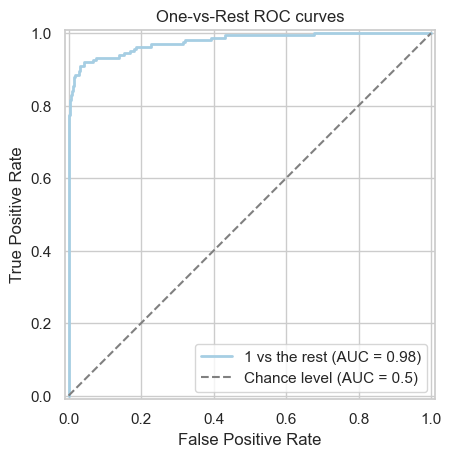

In [59]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_val = label_binarizer.transform(y_val)
y_score = model_lgbm.predict_proba(X_val)
class_of_interest = 1
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

c = sns.color_palette("Paired")[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_val[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color=c,
    plot_chance_level=True,
    chance_level_kw={"color": "gray", "linestyle": "--", "lw": 1.5},
    lw=2,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves",
)

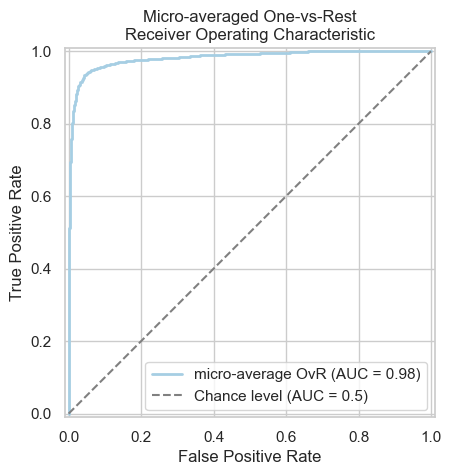

In [60]:
c = sns.color_palette("Paired")[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_val.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color=c,
    plot_chance_level=True,
    chance_level_kw={"color": "gray", "linestyle": "--", "lw": 1.5},
    lw=2,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [49]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.98


In [50]:
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.97


In [51]:
macro_roc_auc_ovr = roc_auc_score(
    y_val,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.97


Text(0.5, 0.98, 'Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass')

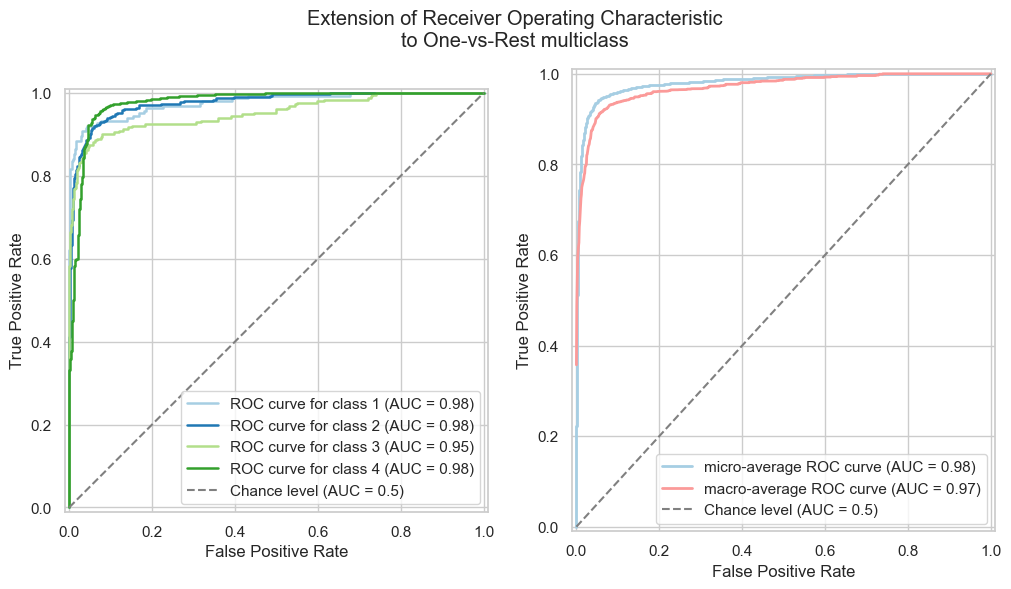

In [72]:
from itertools import cycle

target_names=['class 1', 'class 2', 'class 3','class 4']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

c1, c2 = sns.color_palette("Paired")[0], sns.color_palette("Paired")[4]
ax2.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color=c1,
    lw=2,
)

ax2.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color=c2,
    lw=2,
)
ax2.plot([0, 1], [0, 1], color="gray", lw=1.5, linestyle="--", label="Chance level (AUC = 0.5)")
ax2.set_xlim([-0.01, 1.01])
ax2.set_ylim([-0.01, 1.01])
ax2.legend()

colors = cycle(sns.color_palette("Paired"))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_val[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax1,
        plot_chance_level=(class_id == 3),
        chance_level_kw={"color": "gray", "linestyle": "--", "lw": 1.5},
        lw=1.8,
    )

_ = ax1.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
_ = ax2.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
fig.suptitle("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")

### Random Forest

In [53]:
model_rfc = Pipeline([
    ('model', RandomForestClassifier(
        n_estimators=100,
        criterion='log_loss',
        max_features=None,
        class_weight='balanced_subsample'
    )),
])

In [54]:
model_rfc.fit(X_train, y_train)

Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='log_loss',
                                        max_features=None))])

In [55]:
print(classification_report(y_val, model_rfc.predict(X_val), target_names=['class 1', 'class 2', 'class 3', 'class 4']))

              precision    recall  f1-score   support

     class 1       0.95      0.83      0.89       164
     class 2       0.93      0.86      0.89       311
     class 3       0.96      0.79      0.86       254
     class 4       0.93      0.99      0.96      1183

    accuracy                           0.93      1912
   macro avg       0.94      0.87      0.90      1912
weighted avg       0.93      0.93      0.93      1912



## Submission

In [56]:
submission = pd.DataFrame({'Id': test_ids, 'Target': model_lgbm.predict(test)})
submission.to_csv('submission.csv', index = False)